In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Load and preprocess the data
df = pd.read_csv("./combined_forest.csv")

In [9]:
# Load and preprocess the data
df = pd.read_csv("./combined_forest.csv")
min_max_values = df.drop(columns=['acq_date', 'fire']).agg(['min', 'max'])

for column in df.columns:
    if column not in ['acq_date', 'fire']:
        x_min = min_max_values.loc['min', column]
        x_max = min_max_values.loc['max', column]
        df[f'std_{column}'] = (df[column] - x_min) / (x_max - x_min)

df.drop(columns=['acq_date'], inplace=True)
df.rename(columns={'DEM': 'elevation'}, inplace=True)
df.rename(columns={'std_DEM': 'std_elevation'}, inplace=True)



In [10]:
# Handle missing values
df_cleaned = df.dropna()

In [11]:
# Separate features and target variable 
X = df_cleaned.drop(columns=['fire'])
y = df_cleaned['fire']

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [13]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [14]:
# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

/Users/chema./Documents/Programming/GuadaHack/MLmodel/ForestForecastML/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [16]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))


Epoch 1/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.7029 - loss: 0.5215 - val_accuracy: 0.7649 - val_loss: 0.4563
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.7502 - loss: 0.4465 - val_accuracy: 0.7766 - val_loss: 0.4563
Epoch 3/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.7696 - loss: 0.4409 - val_accuracy: 0.7583 - val_loss: 0.4631
Epoch 4/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.7662 - loss: 0.4357 - val_accuracy: 0.7675 - val_loss: 0.4454
Epoch 5/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.7646 - loss: 0.4330 - val_accuracy: 0.7773 - val_loss: 0.4352
Epoch 6/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.7683 - loss: 0.4393 - val_accuracy: 0.7910 - val_loss: 0.4295
Epoch 7/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.7772 - loss: 0.4163 - val_accuracy: 0.7864 - val_loss: 0.4275
Epoch 8/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - accuracy: 0.7789 - loss: 0.4327 - 

In [17]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
confusion = confusion_matrix(y_test_classes, y_pred_classes)
classification_rep = classification_report(y_test_classes, y_pred_classes)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_rep)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
Accuracy: 0.80
Confusion Matrix:
[[868 161]
 [152 350]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1029
           1       0.68      0.70      0.69       502

    accuracy                           0.80      1531
   macro avg       0.77      0.77      0.77      1531
weighted avg       0.80      0.80      0.80      1531



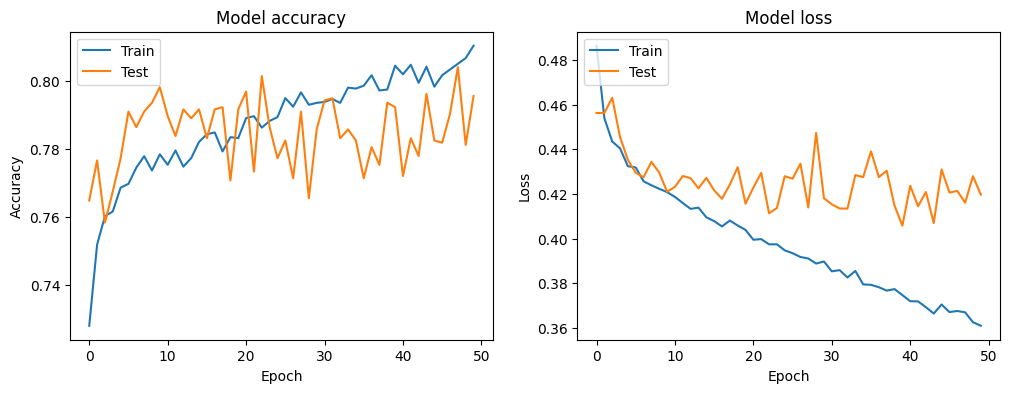

In [18]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()